<a href="https://colab.research.google.com/github/diplomado-bigdata-machinelearning-udea/Curso1/blob/master/s08/s08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="140px" src="https://upload.wikimedia.org/wikipedia/commons/archive/f/fb/20161010213812%21Escudo-UdeA.svg" align="left" hspace="10px" vspace="0px"></p>

<h1> Diplomado de Análisis de datos y Machine Learning en Python</h1>


El presente diplomado hace parte del centro de Big Data de la facultad de ciencias exactas y naturales (FCEN) de la Universidad de Antioquia.

<p><a name="contents"></a></p>

# Contenido Sesión 8: Clasificación:

- <a href="#msel">1. Selección de Modelos.</a><br>
 - <a href="#mod_val">1.1 Validación del modelo</a><br>
 - <a href="#bias_var">1.2 Compensación del sesgo/varianza</a><br>
 - <a href="#val_cur">1.3 Curvas de validación</a><br>
 - <a href="#lea_cur">1.4 Curvas de aprendizaje</a><br>
 - <a href="#bstrap">1.5 Bootstrapping.</a><br>
 - <a href="#g_search">1.6 Grid search.</a><br>
- <a href="#intro">2. Clasificación.</a><br>
 - <a href="#svm">2.1. Máquinas de soporte vectorial</code></a><br>
 - <a href="#reg_log">2.2. Regresión logística.</a><br>



# 1. Selección de Modelos:
<p><a name="msel"></a></p>

[[Contenidos]](#contents)

En las sesiones anteriores hemos visto la receta básica de cómo aplicar un modelo de aprendizaje supervisado en ML.

* Escoger una clase de modelo
* Escoger los hiperparámetros del modelo
* Ajustar el modelo a los datos de entrenamiento
* Usar el modelo para predecir etiquetas para nuevos datos

La elección del modelo y de los hiperparámetros es tal vez la parte más importante para darle un uso efectivo a estas herramientas y técnicas. Para tomar una decisión acertada respecto a qué modelo e hiperparámetros elegir, necesitamos una forma de validar que estos se ajusten bien a los datos.


## 1.1 Validación del modelo
<p><a name="mod_val"></a></p>

[[Contenidos]](#contents)

En principio, la validación del modelo es muy simple: después de elegir un modelo y sus hiperparámetros, podemos estimar qué tan efectivo es este al aplicarlo a algunos de los datos de entrenamiento y comparar la predicción con el valor conocido. Podemos tener una mejor idea del rendimiento de un modelo haciendo lo siguiente: Extraemos un subconjunto de los datos de entrenamiento y luego usamos este subconjunto para verificar el rendimiento del modelo. Una desventaja de usar este método para la validación del modelo es que hemos perdido una parte de nuestros datos en el entrenamiento del modelo.

Una forma de resolver esto es utilizar lo que se conoce como *validación cruzada* (VC): hacer una secuencia de ajustes donde cada subconjunto de datos se use como un conjunto de entrenamiento y como un conjunto de validación. La siguiente figura ilustra el proceso

![picture](https://www.analyticslane.com/wp-content/uploads/2018/07/validacion_cruzada.jpeg)

Dividimos los datos en tres grupos, y usamos cada uno de ellos para evaluar el ajuste del modelo en los otros 2/3 de los datos. Como salida tendremos tres puntajes de desempeño del modelo, que podríamos combinar (por ejemplo, tomando la media) para obtener una mejor medición del rendimiento del modelo global. Esto sería bastante tedioso de hacer a mano, por lo que podemos usar el módulo `cross_val_score` de Scikit-Learn:

In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics

X, y = load_diabetes(return_X_y = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

modelo = LinearRegression(normalize = True)

puntajes = cross_val_score(modelo, X, y, scoring = "r2", cv = 3)
puntajes

array([0.46930578, 0.48724994, 0.50955259])

La repetición de la validación en diferentes subconjuntos de datos nos da una idea aún mejor del rendimiento del algoritmo. El esquema que acabamos de ver, que se implementa por defecto, se conoce como k-fold VC. Scikit-Learn implementa una serie de esquemas de VC que son útiles en situaciones particulares; Estos se implementan a través de iteradores en el módulo [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html). También puede visitar la documentación del parámetro [scoring](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) para ver las métricas usadas para las diferentes tareas.

## Compensación del sesgo/varianza
<p><a name="bias_var"></a></p>

[[Contenidos]](#contents)

Fundamentalmente, la cuestión del "mejor modelo" se trata de encontrar un punto óptimo en el equilibrio entre sesgo y varianza. (El sesgo es la incapacidad que tiene el modelo en ajustar los datos). La siguiente figura presenta dos ajustes de regresión al mismo conjunto de datos.


![picture](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.03-bias-variance.png?raw=true)


Está claro que ninguno de estos modelos se ajusta particularmente bien a los datos, pero fallan de diferentes maneras:

El modelo de la izquierda intenta ajustar una línea recta a través de los datos. Debido a que los datos son intrínsecamente más complicados que una línea recta, el modelo de línea recta nunca podrá describir bien este conjunto de datos. Decimos entonces que el modelo tiene un sesgo alto. 

El modelo de la derecha ajusta los datos mediante un polinomio de grado superior. El ajuste del modelo tiene suficiente flexibilidad para explicar casi perfectamente las características finas en los datos. Decimos entonces que el modelo tiene un sesgo bajo.

Consideremos ahora también los datos de prueba

![picture](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.03-bias-variance-2.png?raw=true)

Aunque el modelo de la derecha se ajustaba mucho mejor a los datos de entrenamiento, tiene un rendimiento pésimo sobre los datos de prueba. Decimos entonces que este modelo tiene una alta varianza. Se dice que el modelo *sobreajusta* los datos. Para el caso del modelo de la izquierda, el rendimiento con ambos conjuntos es muy similar, por lo que tiene una baja varianza. sin embargo, por su naturaleza lineal, como mencionamos, nunca podrá ajustar los datos de manera correcta, por lo que decimos que el modelo *subajusta*  los datos.

Si imaginamos que tenemos alguna capacidad para ajustar la complejidad del modelo, esperaríamos que el puntaje de entrenamiento y el puntaje de prueba se comporten como se ilustra en la siguiente figura


![picture](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.03-validation-curve.png?raw=true)

* El puntaje de entrenamiento siempre es más alto que el puntaje de prueba. 
* Para una complejidad de modelo muy baja (un modelo con alto sesgo), los datos de entrenamiento no son adecuados, lo que significa que el modelo es un mal predictor tanto para los datos de entrenamiento como para cualquier dato no visto previamente.
* Para una complejidad de modelo muy alta (un modelo con alta varianza), los datos de entrenamiento están sobreajustados, lo que significa que el modelo predice muy bien los datos de entrenamiento, pero falla para cualquier dato no visto previamente.
* Para algún valor intermedio, la curva de validación tiene un máximo. Este nivel de complejidad indica una compensación adecuada entre sesgo y varianza.

## 1.3 Curvas de validación

<p><a name="val_cur"></a></p>

[[Contenidos]](#contents)

Veamos un ejemplo de uso de validación cruzada para calcular la curva de validación para un modelo de regresión polinomial. Utilizaremos un *pipeline* que contenga la operación de preprocesamiento polinomial (`PolynomialFeatures`) y la regresión lineal (`LinearRegression`)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

Generemos unos datos para ajustar el modelo

In [ ]:
import numpy as np

def datos(N, err=1.0, rseed=1):
    # generar datos de forma aleatoria
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = datos(40)

Ahora podemos visualizar nuestros datos, junto con ajustes polinómicos de varios grados.

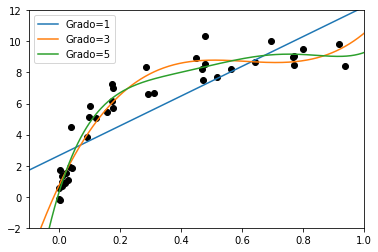

In [ ]:
import matplotlib.pyplot as plt

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='Grado={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

Lo que controla la complejidad del modelo en este caso es el grado del polinomio. ¿qué grado de polinomio proporciona una compensación adecuada entre el sesgo (subajuste) y la varianza (sobreajuste)?

Podemos visualizar la curva de validación para este modelo y datos particulares; Esto se puede hacer directamente usando la función validation_curve provista por Scikit-Learn. Dado un modelo, datos, nombre de parámetro y un rango para explorar, esta función calculará automáticamente tanto el puntaje de entrenamiento como el puntaje de validación en todo el rango

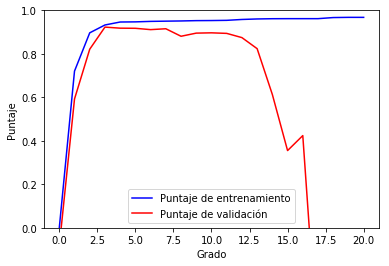

In [ ]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='Puntaje de entrenamiento')
plt.plot(degree, np.median(val_score, 1), color='red', label='Puntaje de validación')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('Grado')
plt.ylabel('Puntaje');

Esto muestra con precisión el comportamiento cualitativo que esperamos: el puntaje de entrenamiento es en todas partes más alto que el puntaje de validación; el puntaje de entrenamiento mejora monotónicamente con una mayor complejidad del modelo; y la puntuación de validación alcanza un máximo antes de caerse a medida que el modelo se sobreajusta.

A partir de la curva de validación, podemos deducir que el equilibrio óptimo entre sesgo y varianza se encuentra para un polinomio de tercer orden:

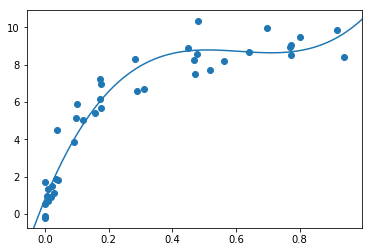

In [ ]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

## 1.4 Curvas de aprendizaje
<p><a name="lea_cur"></a></p>

[[Contenidos]](#contents)

Un aspecto importante de la complejidad del modelo es que el modelo óptimo generalmente dependerá del tamaño de los datos de entrenamiento. Por ejemplo, generemos un nuevo conjunto de datos con un factor de cinco puntos más:


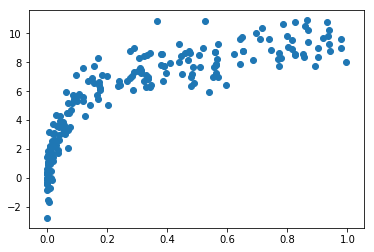

In [ ]:
X2, y2 = datos(200)
plt.scatter(X2.ravel(), y2);

Trazemos la curva de validación

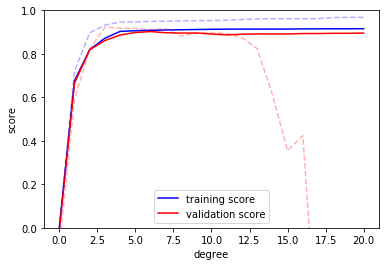

In [ ]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

Las líneas continuas muestran los nuevos resultados, mientras que las líneas discontinuas más débiles muestran los resultados del conjunto de datos anterior más pequeño. A partir de la curva de validación, es claro que el conjunto de datos más grande puede admitir un modelo mucho más complicado: el pico se da alrededor de un grado 6, pero incluso un modelo de grado 20 no está sobreajustando los datos: los puntajes de entrenamiento y de validación están muy cercanos. Por lo tanto, vemos que el comportamiento de la curva de validación no tiene una sino dos entradas importantes: la complejidad del modelo y el número de puntos de entrenamiento.

Scikit-Learn ofrece una práctica utilidad para calcular tales curvas de aprendizaje de sus modelos; Aquí calcularemos una curva de aprendizaje para nuestro conjunto de datos original con un modelo polinomial de segundo orden y un polinomio de noveno orden:

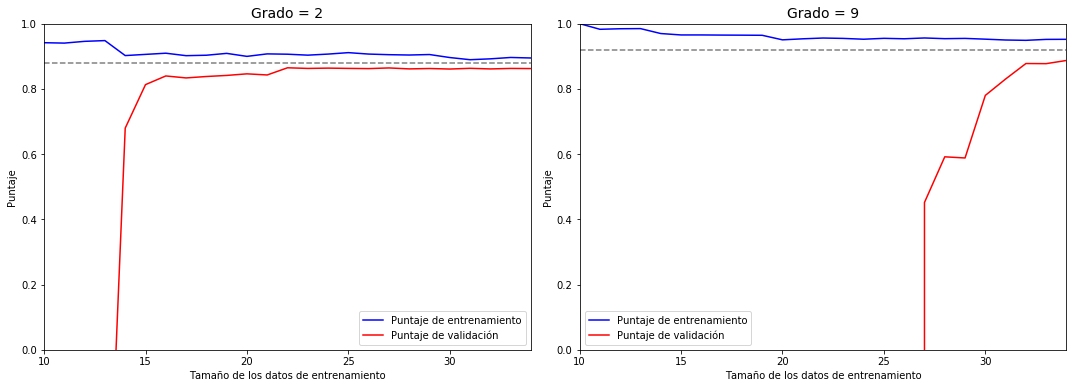

In [ ]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='Puntaje de entrenamiento')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='Puntaje de validación')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('Tamaño de los datos de entrenamiento')
    ax[i].set_ylabel('Puntaje')
    ax[i].set_title('Grado = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

Este es un diagnóstico valioso, porque nos da una descripción visual de cómo nuestro modelo responde al aumento de los datos de entrenamiento. En particular, cuando la curva de aprendizaje ya ha convergido (es decir, cuando las curvas de entrenamiento y validación ya están cercanas entre sí), ¡agregar más datos de entrenamiento no mejorará significativamente el ajuste! Esta situación se ve en el panel izquierdo, con la curva de aprendizaje para el modelo de grado 2.

Trazar una curva de aprendizaje para nuestra elección particular de modelo y conjunto de datos puede ayudarnos a tomar una decisión sobre cómo avanzar para mejorar el análisis.

## 1.5 Bootstraping
<p><a name="bstrap"></a></p>

[[Contenidos]](#contents)

También nos es posible hacer la validación del modelo haciendo un particionado de nuestros datos de tal forma que sea posible un remuestreo de los datos, con ello es posible generar estadísticas con niveles de confianza, algo que no es posible si usamos otros métodos como CV.

La partición del dataset se haría de la siguiente forma:



*   Seleccionar un tamaño de muestra de entrenamiento que se desea.
*   Mientras el tamaño sea menor que el tamaño elegido.
  * Seleccionar una instancia de forma aleatoria y añadirla a la muestra.
* Todos los datos que no hayan sido elegidos para la muestra de entrenamiento serán elegidos como muestra de test. A éstos datos se les conoce generalmente como out of bags (fuera de la bolsa).

Note que en la selección es posible que una instancia sea elegida más de una vez para hacer parte de la muestra de entrenamieto, sin embargo jamás habrán instancias en ambas muestras (train, test).

Así es posible generar estadísticas de la robustes de nuestro algoritmo sobre datos nunca vistos.


En general entonces el procedimiento de validación por bootstrap será:



*   Elija un numero de repeticiones de bootstrap.
*   Elija un tamaño de muestra. 
*   Para cada muestra de bootstrap.
  *  Haga una partición como se indicó anteriormente.
  *  Entrene el modelo con la muestra de entrenamiento.
  *  Haga el estimado del error de predicción del modelo con la metrica elegida sobre la muestra de test.
* Calcume la media y la varianza de sus errores.

Una ventaja de éste método es que las estimaciones deben distribuirse de forma gaussiana.

**Tenga en cuenta que:**
El tamaño elegido para la muestra del bootstrap por lo general es el mismo tamaño del dataset, a menos que tengamos un dataset demasiado grande y su costo computacional sea excesivo, en dichos casos suele usarse al rededor de un 50%.

El numero de repeticiones debe ser grande, de tal forma que se genere estadística, se aconseja que como mínimo sean 30 repeticiones.


![picture](https://d3ansictanv2wj.cloudfront.net/emlm_0302-6a388b903f6e1e04c95e718940eff039.png)




In [ ]:
from sklearn.utils import resample #metodo de muestreo con remplazo
data = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
#crear la muestra de bootstrap 
boot = resample(data, replace=True, n_samples=5, random_state=3)
print('Bootstrap:',boot)
# out of bag 
oob = [x for x in data if x not in boot]
print('OOB:',oob)

Bootstrap: [0.3, 0.1, 0.2, 0.4, 0.1]
OOB: [0.5, 0.6]


Validemos con éste método sobre un modelo lineal de los creados en clases pasadas:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn import metrics


df=pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/FuelConsumptionCo2.csv')
df.dropna(inplace=True)
data= df[['ENGINESIZE','CO2EMISSIONS']].values

MAE = []
n_rep = 40

for i in range(n_rep):
  boot = resample(data, replace=True, n_samples=int(len(data)/2))
  oob = np.array([x for x in data if x.tolist() not in boot.tolist()])
   
  X_train = boot[:,0].reshape(-1,1)
  y_train = boot[:,1]
  X_test = oob[:,0].reshape(-1,1)
  y_test = oob[:,1]
  #entrenamos el modelo
  elastic = ElasticNet(alpha=0.01,l1_ratio=1,normalize=True)
  elastic.fit(X_train,y_train)
  y_pred = elastic.predict(X_test)
  mae = metrics.mean_absolute_error(y_test, y_pred)
  MAE.append(mae)

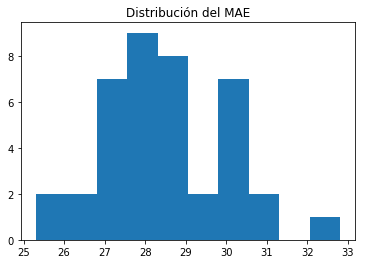

In [ ]:
import matplotlib.pyplot as plt
plt.hist(MAE)
plt.title(r'Distribución del MAE')
plt.show()

In [ ]:
media = np.mean(MAE)
dstd = np.std(MAE)
print('Error MAE:',media,'+/-',dstd)

Error MAE: 28.490130084837098 +/- 1.5255413096410302


Como vemos es posible generar estadísticas sobre nuestros errores y su distribución, además de su intervalo de confianza, así podemos hacer afirmaciones con mayor certeza dobre la robustez de nuetro modelo.

## 1.6 Gridsearch para la optimización de hiper-parámetros
<p><a name="gridsearch"></a></p>

[[Contenidos]](#contents)

Un paso fundamental en cualquier modelado es el ajuste de los hiper-parámetros para generar un modelo cuya compenzación sesgo/varianza sea optima.

La idea básica es, como se hizo en la sesión pasada, explorar un amplio espacio de hiper-parámetros haciendo combinaciones posibles de ellos y usando alguna metrica escoger el mejor posible.

En scikit-learn nos es posible hacerlo de dos formas:



*   Haciendo un barrido completo de las combinaciones de hiper-parámetros (GridSearchCV)
*   Haciendo un barrido aleatorio de las combinaciones de hiper-parámetros (RandomizedSearchCV)

El primero es útil si deseamos tener un conocimiento mejor de nuestro espacio de hiper-parámetros, pero no es aconsejable si son demasiadas combinaciones o si nuestro algoritmo es lento en entrenamiento.
Ambos métodos los encontrarémos en 'sklearn.model_selection'


https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.svm import SVR

df=pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/FuelConsumptionCo2.csv')
X = df['ENGINESIZE'].values.reshape(-1,1)
y = df['CO2EMISSIONS'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=3)


# creamos los diccionarios sobre los que exploraremos
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]


#para ver las posibles metricas: https://scikit-learn.org/stable/modules/model_evaluation.html

clf = GridSearchCV(SVR(), tuned_parameters, cv=5,scoring= 'r2')
clf.fit(X_train, y_train)

print("Mejor conjunto de parámetros:")
print()
print(clf.best_params_)
print()
print("Media y desviación:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))


Mejor conjunto de parámetros:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Media y desviación:

0.037 (+/-0.029) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
-0.011 (+/-0.032) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.396 (+/-0.041) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.038 (+/-0.029) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.746 (+/-0.036) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.398 (+/-0.042) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.762 (+/-0.035) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.746 (+/-0.035) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.761 (+/-0.035) for {'C': 1, 'kernel': 'linear'}
0.762 (+/-0.035) for {'C': 10, 'kernel': 'linear'}
0.762 (+/-0.035) for {'C': 100, 'kernel': 'linear'}
0.762 (+/-0.035) for {'C': 1000, 'kernel': 'linear'}


#### Ejercicio:

1. En el dataset de autos (a1): elimine los datos faltantes, convierta las variables categoricas en variables dummies (a2), y separe el dataset en datos de entrenamiento y prueba.

2. Use GridSearchCV para explorar el espacio de hiper-parámetros compuesto por $\alpha$ en la lista [0.01,0.1,1,10,100,1000] y l1_ratio en [0.1,0.3,0.6,0.9,0.99,0.999], entrenando  ElasticNet y evaluandolo con RMSE. 

3. ¿Cuál es el mejor conjunto de hiper-parámetros?, ¿cuál es la media y la desviación del error en cada conjunto de hiper-parámetros?.


a1. 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DA0101EN/automobileEDA.csv'

a2. `pd.get_dummies()`



Hacer doble click <b>aquí</b> para ver la solución:

<!-- Respuesta:

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
import pandas as pd

df =pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DA0101EN/automobileEDA.csv')
#eliminamos datos nulos
df.dropna(inplace=True)
#creamos las variables dummies
df_dummies = pd.get_dummies(df)
#separamos el dataset
X = df_dummies.drop('price',axis=1)
y = df_dummies['price']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

# creamos los diccionarios sobre los que exploraremos
tuned_parameters = [{'alpha': [0.01,0.1,1,10,100,1000],'l1_ratio':[0.1,0.3,0.6,0.9,0.99,0.999]}]

#para ver las posibles metricas: https://scikit-learn.org/stable/modules/model_evaluation.html

clf = GridSearchCV(ElasticNet(tol=0.05),tuned_parameters,cv=5,scoring= 'neg_mean_squared_error')
clf.fit(X_train, y_train)

print("Mejor conjunto de parámetros:")
print()
print(clf.best_params_)
print()
print("Media y desviación:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

-->

# 2. Clasificación:
<p><a name="intro"></a></p>

[[Contenidos]](#contents)


El el objetivo en la **clasificación** es predecir una clase, que corresponde a una opción entre una lista predefinida de posibilidades. El problema de clasificación puede separarse en dos categorías:

* Clasificación binaria: cuyo proposito consiste en estimar si una instacia corresponde a una clase de dos posibles. La clasificación binaria puede pensarsar como el dar respuesta de si o no a una pregunta; clasificar un paciente como enfermo o sano, respecto a una enfermedad; clasificar un correo como spam o no; etc.

* Clasificación multi-clase: en donde se estima si una instacia corresponde a una clase de mas de dos clases posibles. Algunos ejemplos de clasificación multi-clases en ML consiten en la clasificación de plantas de diferentes especies; clasificación para predecir el lenguaje de una determinada página Web; etc.

Recordemos que el problema de **regresión**  consiste en la determinación de una una variable objetivo continua, mientras que en el problema de **clasificación** se busca poner un conjunto de etiquetas finitas a las instancias de la tabla.

## 2.1 Clasificador: Máquina de soporte vectorial

<p><a name="svm"></a></p>

[[Contenidos]](#contents)

Supogamos que tenemos un dataset con dos características y  queremos clasificar con una línea recta (hiperplano en el caso de mas dimensiones) a que grupo (rojos o azules) corresponde cada uno. 

<p><img height="230px" src="https://miro.medium.com/max/300/0*9jEWNXTAao7phK-5.png"  hspace="10px" vspace="0px">
  <img height="230px" src="https://miro.medium.com/max/300/0*0o8xIA4k3gXUDCFU.png"  hspace="10px" vspace="0px"></p>


En la figura de la izquierda, podemos ver que tenemos "infinitas" rectas que sirven para clasificar los dos grupos. En SVM escogemos la recta (hiperplano) que maximiza el margen, entendiendo como el margen la distacia maxima que hay entre los puntos de las dos clases. Los puntos que están mas cerca de la frontera (línea punteada) se conocen como los vectores de soporte, estos pueden quedar sobre la línea de frontera o fuera de ella. En la figura de la derecha son datos que aparecen con el color relleno.  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# copiando el archivo mlutils.py en la carpeta local
!wget "https://raw.githubusercontent.com/diplomado-bigdata-machinelearning-udea/Curso1/master/s06/mlutils.py"
import mlutils

--2019-09-13 21:54:39--  https://raw.githubusercontent.com/diplomado-bigdata-machinelearning-udea/Curso1/master/s06/mlutils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10691 (10K) [text/plain]
Saving to: ‘mlutils.py.3’

mlutils.py.3        100%[===================>]  10.44K  --.-KB/s    in 0s      

2019-09-13 21:54:39 (89.5 MB/s) - ‘mlutils.py.3’ saved [10691/10691]



In [ ]:
from sklearn.datasets import *
from sklearn.model_selection import train_test_split

### Clasificador Lineal binario

In [ ]:
X,y = make_blobs(400, centers=2, cluster_std=1, random_state=0)
X.shape, y.shape


((400, 2), (400,))

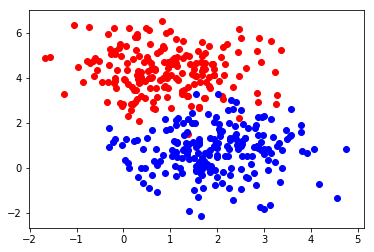

In [ ]:
plt.scatter(X[y==0][:,0], X[y==0][:,1], color="red")
plt.scatter(X[y==1][:,0], X[y==1][:,1], color="blue")

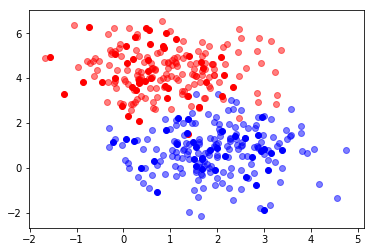

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=100)

plt.scatter(X_train[y_train==0][:,0], X_train[y_train==0][:,1], color="red", alpha=0.5)
plt.scatter(X_train[y_train==1][:,0], X_train[y_train==1][:,1], color="blue", alpha=0.5)

plt.scatter(X_test[y_test==0][:,0], X_test[y_test==0][:,1], color="red")
plt.scatter(X_test[y_test==1][:,0], X_test[y_test==1][:,1], color="blue")

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

C= 0.01
score_train 0.953125
score_test 0.95


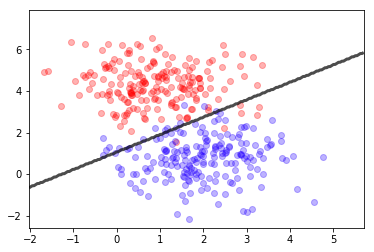

C= 0.1
score_train 0.971875
score_test 0.9875


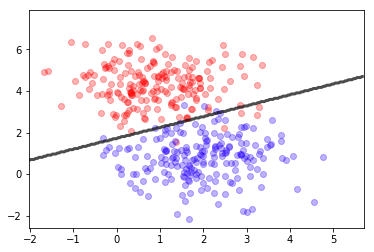

C= 1.0
score_train 0.978125
score_test 0.975


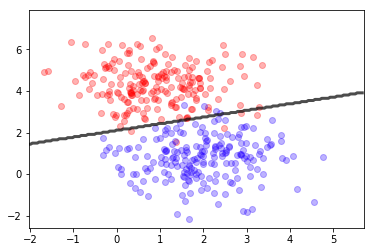

C= 10.0
score_train 0.98125
score_test 0.975


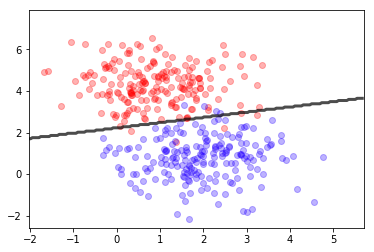

In [ ]:
for C_param in np.array([0.01,0.1,1.0,10]):
  sv = LinearSVC(C=C_param, max_iter=10000)
  sv.fit(X_train,y_train)
  print ("C=", C_param)
  print ("score_train",sv.score(X_train,y_train))
  print ("score_test",sv.score(X_test,y_test))
  mlutils.plot_2Ddata(X, y, dots_alpha=.3)
  mlutils.plot_2D_boundary(sv.predict, np.min(X, axis=0), np.max(X, axis=0),
                   line_width=3, line_alpha=.7, label=None)
  plt.show()


Para LinearSVC el parámetro C determina la regularización. Valores altos de C corresponden con baja regularización. En otras palábras, para valores altos de C el algoritmo trata de ajustarse al set de entrenamiento lo mejor posible, mientras que para valores bajos de C, el algoritmo agrega penalidad a los pesos altos, similar a la función del hiperparámetro $\alpha$ en la regresión de Ridge.


Si usamos el método SVC con kernel lineal, podemos ver cuantos y  cuales son los vectores de soporte que está utilizando el algoritmo.

number of support vectors 27


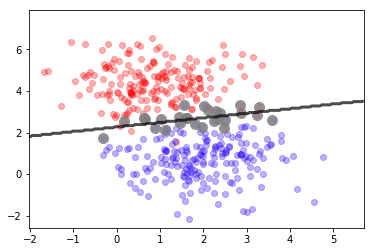

In [ ]:
sv = SVC(kernel='linear')
sv.fit(X_train,y_train)
mlutils.plot_2Ddata(X, y, dots_alpha=.3)
mlutils.plot_2D_boundary(sv.predict, np.min(X, axis=0), np.max(X, axis=0),
                 line_width=3, line_alpha=.7, label=None)
plt.scatter(sv.support_vectors_[:,0], sv.support_vectors_[:,1], s=100, alpha=.8, color="gray")
print ("number of support vectors", len(sv.support_vectors_))

### Clasificador Lineal Múlticlase

In [ ]:
!pip install mglearn

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


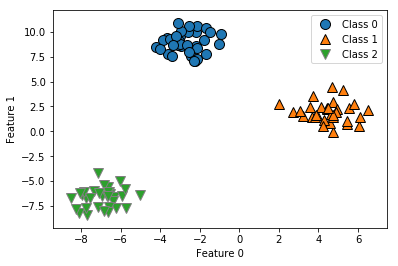

In [ ]:
import mglearn
X, y = make_blobs(random_state=42)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(["Class 0", "Class 1", "Class 2"])
plt.show()


Como en este caso son tres clases, lo que tenemos es un clasificador lineal para cada una de ellas

In [ ]:
linear_svm = LinearSVC().fit(X, y)

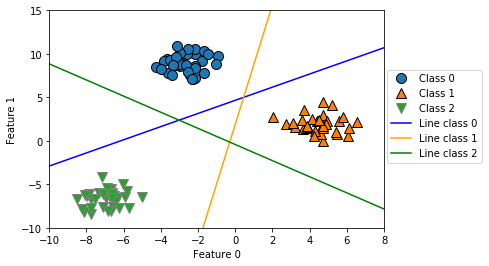

In [ ]:
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
line = np.linspace(-15, 15)
for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_,
['b', 'orange', 'g']):
  plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
plt.ylim(-10, 15)
plt.xlim(-10, 8)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(['Class 0', 'Class 1', 'Class 2', 'Line class 0', 'Line class 1',
'Line class 2'], loc=(1.01, 0.3))

en este punto nos podemos preguntar: ¿Qué pasa con los puntos que pueden estar dentro del triángulo formado por las intersecciones? Esos puntos se clasificarán dependiendo de la línea que tengan más cercana.   


In [ ]:
mglearn.plots.plot_2d_classification?

Text(0, 0.5, 'Feature 1')

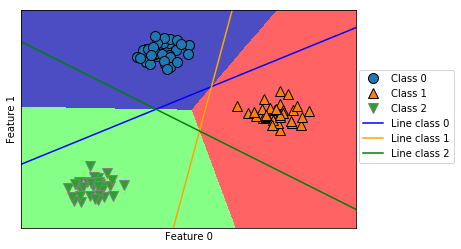

In [ ]:
mglearn.plots.plot_2d_classification(linear_svm, X, fill=True, alpha=.7)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
line = np.linspace(-15, 15)
for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_,
['b', 'orange', 'g']):
  plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
plt.legend(['Class 0', 'Class 1', 'Class 2', 'Line class 0', 'Line class 1',
'Line class 2'], loc=(1.01, 0.3))
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")


### Clasificador no lineal

Igual a como vimos en la regresión usando máquinas de soporte vectorial, "el truco" para resolver problemas de clasificación que no sean lineales, es usando un kernel que mapea los datos a un espacio de mayor dimensionalidad.   

Text(0, 0.5, 'Feature 1')

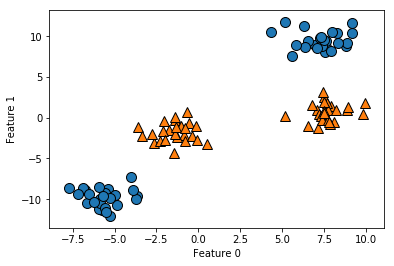

In [ ]:
X, y = make_blobs(centers=4, random_state=8)
y = y % 2
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

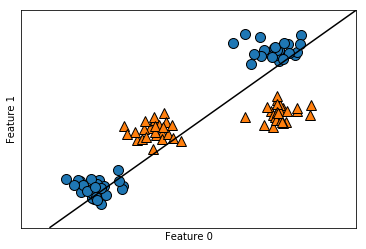

In [ ]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC(max_iter=10000).fit(X, y)
mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

Text(0.5, 0, 'feature1 ** 2')

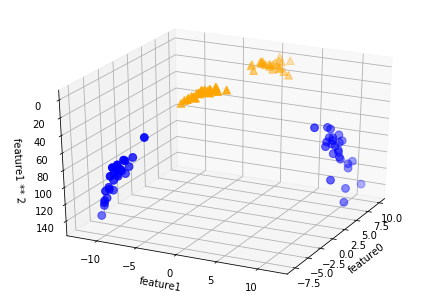

In [ ]:
# add the squared first feature
X_new = np.hstack([X, X[:, 1:] ** 2])
from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()
# visualize in 3D
ax = Axes3D(figure, elev=-152, azim=-26)
# plot first all the points with y == 0, then all with y == 1
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='orange', marker='^',
cmap=mglearn.cm2, s=60)
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0.5, 0, 'feature0 ** 2')

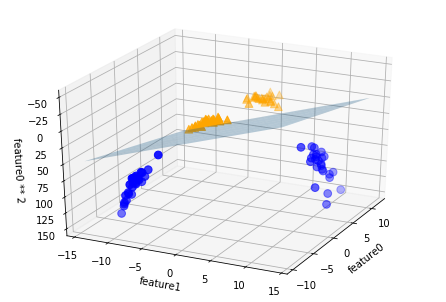

In [ ]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_
# show linear decision boundary
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)
XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='orange', marker='^',
cmap=mglearn.cm2, s=60)
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature0 ** 2")


Text(0, 0.5, 'Feature 1')

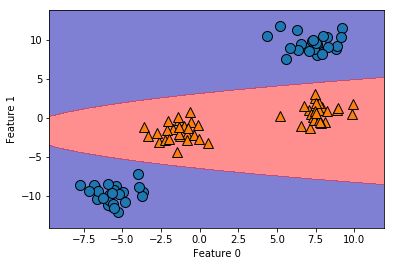

In [ ]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

### Usando los kernel
Igual que para la regresión, los kernel disponibles en sklearn son lineal ('linear'), polinómico ('poly'), función de base radial ('rbf'), sigmoide('sigmoid'). El hiperparámetro $\gamma$ está asociado a los coeficientes de los kernel. Veamos por ejempĺo en el caso del kernel de base radial (RBF) $K_{rbf}=\exp(-\gamma |x_1-x_2|^2)$ la dependencia de $\gamma$ en la clasificación. En este caso lo podemos interpretar como *cuanto de cercanos han de estar dos puntos para considerarlos similares*






In [ ]:
X,y = make_moons(400, noise=0.1, random_state=10)

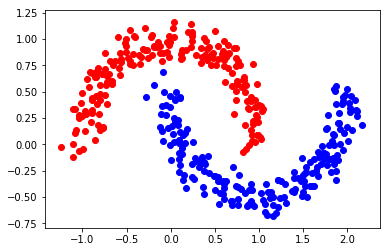

In [ ]:
plt.scatter(X[y==0][:,0], X[y==0][:,1], color="red")
plt.scatter(X[y==1][:,0], X[y==1][:,1], color="blue")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=100)

$\gamma$ pequeño

score_train 0.821875
score_test 0.9125
number of support vectors 198


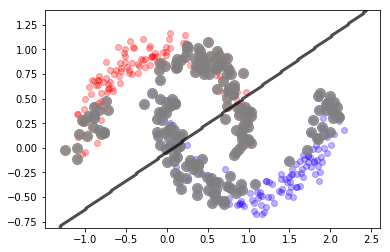

In [ ]:
sv = SVC(gamma=1e-2)
sv.fit(X_train,y_train)
print ("score_train",sv.score(X_train,y_train))
print ("score_test",sv.score(X_test,y_test))
mlutils.plot_2Ddata(X, y, dots_alpha=.3)
mlutils.plot_2D_boundary(sv.predict, np.min(X, axis=0), np.max(X, axis=0),
                 line_width=3, line_alpha=.7, label=None)

plt.scatter(sv.support_vectors_[:,0], sv.support_vectors_[:,1], s=100, alpha=.8, color="gray")
print ("number of support vectors", len(sv.support_vectors_))

$\gamma$ mediano

score_train 0.996875
score_test 1.0
number of support vectors 47


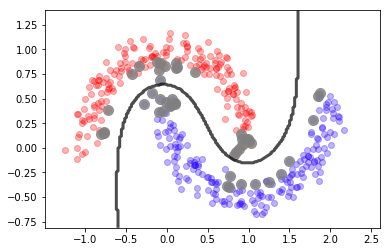

In [ ]:
sv = SVC(gamma=1)
sv.fit(X_train,y_train)
print ("score_train",sv.score(X_train,y_train))
print ("score_test",sv.score(X_test,y_test))
mlutils.plot_2Ddata(X, y, dots_alpha=.3)
mlutils.plot_2D_boundary(sv.predict, np.min(X, axis=0), np.max(X, axis=0),
                 line_width=3, line_alpha=.7, label=None)

plt.scatter(sv.support_vectors_[:,0], sv.support_vectors_[:,1], s=100, alpha=.8, color="gray")
print ("number of support vectors", len(sv.support_vectors_))

$\gamma$ grande

score_train 1.0
score_test 1.0
number of support vectors 211


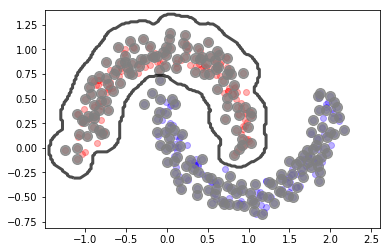

In [ ]:
sv = SVC(gamma=100)
sv.fit(X_train,y_train)
print ("score_train",sv.score(X_train,y_train))
print ("score_test",sv.score(X_test,y_test))
mlutils.plot_2Ddata(X, y, dots_alpha=.3)
mlutils.plot_2D_boundary(sv.predict, np.min(X, axis=0), np.max(X, axis=0),
                 line_width=3, line_alpha=.7, label=None)

plt.scatter(sv.support_vectors_[:,0], sv.support_vectors_[:,1], s=100, alpha=.8, color="gray")
print ("number of support vectors", len(sv.support_vectors_))

## 2.2. Regresión Logística:
<p><a name="reg_log"></a></p>

[[Contenidos]](#contents)

Como se ha mencionado, algunos algoritmos de regresión pueden ser usados para el problema de clasificación. La **Regresión Logística** se usa, comunmente, para determinar la probabilidad de que una instancia pertenezca a una clase particular. 

Supongamos que tenemos dos clases: clase A (clase positiva, etiquetada como 1) y clase B (clase negativa, etiquetada como 0). Si estimamos una probabilidad $\hat{p}$ en regresión logística, tenemos entonces que el problema de clasificación binario se trata de la siguiente forma:

\begin{equation*}
\hat{y} = \begin{cases}
1 &\hat{p}\geq0.5\\
0 &\hat{p}<0.5
\end{cases}
\end{equation*}

Sin entrar en detalles, la probabilidad estimada de $y$ dado x, es tal que 

\begin{equation}
\hat{p}=h_w(\mathbf{x})=\sigma(\mathbf{x}^T\mathbf{w})
\end{equation}

En donde, $\sigma(.)$ representa la función logística, o sigmoide, mediante la cual se obtiene un resultado que esta entre 0 y 1. En la regresión logística **la probabilidad se ajusta a una función sigmoide/logística para realizar el mapeo a probabilidades**. Esta función está definida por la ecuación:

\begin{equation}
\sigma(t)=\frac{e^{t}}{1+e^{-t}}
\end{equation}

Veamos la apariencia que presenta esta función:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Definición de la función sigmoide/logística:

def sigmoide(x):
    output = np.exp(x)/(1+np.exp(x))
    return output

Text(0.5, 1.0, 'Función logística o sigmoide')

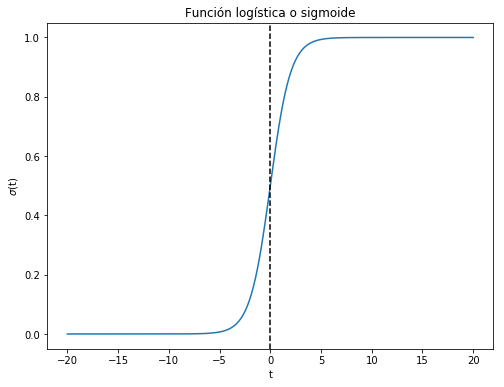

In [ ]:
x = np.linspace(-20,20,400)
y=sigmoide(x)

plt.figure(figsize=(8,6))

plt.plot(x,y)
plt.axvline(x=0,color='k',linestyle='--')
plt.xlabel("t")
plt.ylabel("$\sigma$(t)")
plt.title("Función logística o sigmoide")

obre la función sigmoide podemos advertir varias cosas:

* La función sigmoide tiende rápidamenta a cero para valores negativos.
* La función sigmoide tiende rápidamente a 1 para valores positivos.
* $\sigma(t)<0.5$ si $t<0$.
* $\sigma(t)\geq0.5$ si $t\geq0$.

De los dos últimos ítems se tiene que nuestro modelo de regresión logística predice un valor 1 si $\mathbf{x}^T\mathbf{w}$ es positivo y cero si es negativo.

### Regresión logística vs regresión lineal

Recordemos que en la **regresión lineal** se determina una función que relaciona a una variable dependiente continua, con algunos predictores (variables independientes $x_1$, $x_2$, etc.). Por ejemplo, en la regresión lineal multiple se asume una función de la forma:


\begin{equation}
y = w_0 + w_1x_1 + w_2x_2 + \cdots
\end{equation}

en la que se determinan los valos de los parámetos $w$'s que minimizan el error. Lo anterior puede generalizarse como:


\begin{equation}
ℎ_w(𝑥) = \mathbf{x}^T\mathbf{w}
\end{equation}

La regresión logística es una variación de la regresión lineal, la cual resulta útil en los casos en que la variable dependiente, $\mathbf{y}$, es categórica. Como se mencionó, la regresión logística produce un resultado de la probabilidad que una instancia pertenezca a un clase dada.

La regresión logística ajusta entonces una curva en forma de "S", tomando la regresión lineal ($\mathbf{x}^T\mathbf{w}$) y transformando la estimación numérica en una probabilidad (entre 0 y 1), mediante la función sigmoide:

$$
ℎ_w(𝑥) = \sigma({\mathbf{x}^T\mathbf{w}}) =  \frac {e^{(w_0 + w_1  x_1 + w_2  x_2 +...)}}{1 + e^{(w_0 + w_1  x_1 + w_2  x_2 +\cdots)}}
$$
Or:
$$
\text{Probabilidad_Clase_1} =  P(Y=1|X) = \sigma({\mathbf{x}^T\mathbf{w}}) = \frac{e^{\mathbf{x}^T\mathbf{w}}}{1+e^{\mathbf{x}^T\mathbf{w}}} 
$$

En esta ecuación se tiene que, $\mathbf{x}^T\mathbf{w}$ es el resultado de la regresión (es decir, la suma de las variables/características pesadas por los coeficientes), `exp` representa la función exponencial, $\sigma(\mathbf{x}^T\mathbf{w})$ es la [función logística](http://en.wikipedia.org/wiki/Logistic_function).

De forma sucinta, la regresión logística toma la entrada (argumento) de la función sigmoide/logística y para obtener un resultado de probabilidades:

<img
src="https://ibm.box.com/shared/static/kgv9alcghmjcv97op4d6onkyxevk23b1.png" width="400" align="center">

**Nota**: No deje confundirse visualmente pensando que la sigmoide corresponde a la frontera de decisición. Los datos que se muestran en la gráfica anterior corresponden a dos grupos (0 y 1), y el ajuste lineal de estos es el que se pasa a la función sigmoide para mapearlos a probabilidades 


El proposito del algoritmo de __Regresión Lógistica__ es el de encontrar los parámetros $\mathbf{w}$, para  $ℎ_w(𝑥)$ = $\sigma(\mathbf{x}^T\mathbf{w})$, de tal forma que el modelo prediga más precisamente la clase en cada caso.

El modelo de regresión logística representa entonces un algoritmo apliamente usado en clasificación binaria, en los casos en que la frontera de decisión sea lineal.

Veamos a continuación el desempeño de la regresión logistica en la clasificación de tres distribuciones:

* Regresión logística en un problema de clasificación binaria con una frontera de decisición lineal.
* Regresión logística en un problema de clasificación binaria con una forntera de desición no lineal. 

### Regresión logística en un problema de clasificación binaria con una frontera de decisión lineal.

Para evaluar los casos en el que una regresión logística tiene un buen desempeño, veamos las siguientes distribuciónes de datos generadas en python:

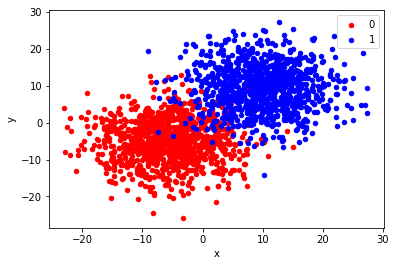

In [ ]:
from sklearn.datasets.samples_generator import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
import matplotlib.pyplot as plt
from pandas import DataFrame

# Generación de un dataset de clasificación 2d de nubes de puntos.
X, y = make_blobs(n_samples=[1000,1000], centers=None, n_features=2, cluster_std=6, random_state=202)
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

La **apariencia del dataset** es la de una tabla con dos características, o variables independientes, y una variable objetivo, o variable dependiente:

In [ ]:
df.head(10)

,x,y,label
0,3.638509,10.367086,1
1,19.869574,6.554166,1
2,-3.596134,0.146057,0
3,-11.827598,-8.025380,0
4,-3.935786,-11.372476,0
5,0.016425,-4.886311,0
6,-4.616008,-5.792576,0
7,-3.427720,-16.442486,0
8,-9.197854,-3.219251,0
9,24.958239,0.800719,1


Las variables independiente están etiquetadas en las columnas como las "características" $\mathbf{x}$ e $\mathbf{y}$, a pesar de que hemos insistido a lo largo del curso reservar la letra $\mathbf{y}$ para la variable objetivo o dependiente. En este caso, la variable objetivo está etiquetada como **label**.

A continuación, veamos los resultados de la clasificación derivada de una regresión logística. Los datos son graficados sobre un contorno que representa la probabilidad de pertenecer a una clase u otra:
 * Los tonos rojos, corresponden a regiones de probalidad menores a 0.5 de pertenecer a la clase 1.
 * Los tonos azules, corresponden a regiones de probabilid  mayores a 0.5 de pertenecer a la clase 1.
 * Los valores en blanco, representan la forntera de decisión, es decir donde se obtiene una probabilidad del 0.5 de pertenencia a la clase 1.

Train set: (1600, 2) (1600,)
Test set: (400, 2) (400,)


[(-22.981715497289997, 27.37181699382255),
 Text(0, 0.5, '$X_2$'),
 (-25.814445291719665, 27.365133706091257),
 Text(0.5, 0, '$X_1$'),
 None]

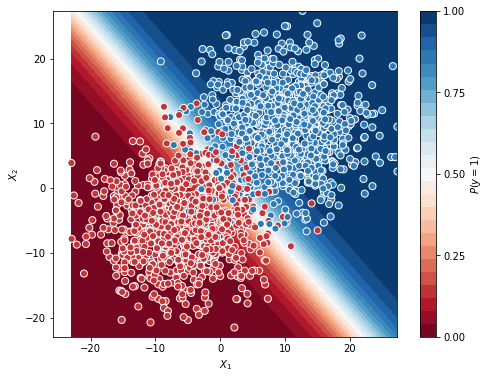

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# División de los datos en subconjuntos de entrenamiento/evaluación.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

# Ajuste del modelo.
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

xx, yy = np.mgrid[X.min(0)[0]:X.max(0)[0]:.01, X.min(0)[1]:X.max(0)[1]:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = LR.predict_proba(grid)[:, 1].reshape(xx.shape)
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(X.min(0)[1], X.max(0)[1]), ylim=(X.min(0)[0], X.max(0)[0]),
       xlabel="$X_1$", ylabel="$X_2$")

Evaluemos ahora la presición del modelo creado mediante regresión logística, realizando una validación cruzada:

In [ ]:
from sklearn.model_selection import cross_val_score

# Validación cruzada con tres folds
cv_scores = cross_val_score(LR,X,y)

print("Los puntajes de la validación cruzada son:", cv_scores)


Los puntajes de la validación cruzada son: [0.95958084 0.94294294 0.93993994]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


**Conclusión:** En los casos en donde la **frontera de decisión** corresponde a una **línea recta**, el algoritmo de desición logística presenta un excelente desempeño en la clasificación de los datos; de hecho, hemos obtenido un porcentaje de clasificaciones correctas del 95%, mediante una evaluación cruzada con tres folds.

### Regresión logística en un problema de clasificación binaria con frontera de decisión no lineal I.

Para evaluar los casos en el que una regresión logística tiene un buen desempeño, veamos el siguiente caso de distribución de datos generadas en python:

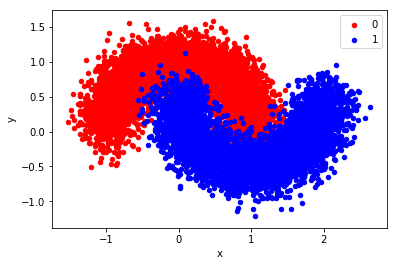

In [ ]:
from sklearn.datasets import make_moons

# generate 2d classification dataset
X, y = make_moons(n_samples=10000, noise=0.2)
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

Train set: (8000, 2) (8000,)
Test set: (2000, 2) (2000,)


[(-1.212651923120385, 1.5863090243750573),
 Text(0, 0.5, '$X_2$'),
 (-1.5237216936143902, 2.6402369251882014),
 Text(0.5, 0, '$X_1$'),
 None]

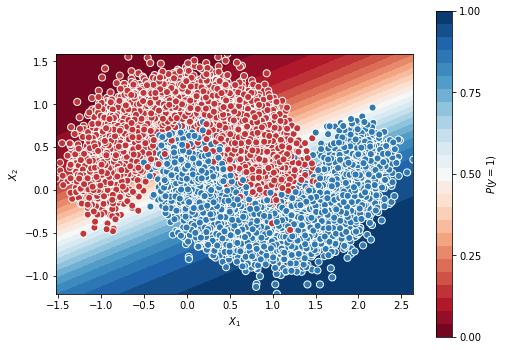

In [ ]:
# División de los datos en subconjuntos de entrenamiento/evaluación.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

# Ajuste del modelo.
LR = LogisticRegression(C=0.01, solver='newton-cg').fit(X_train,y_train)

xx, yy = np.mgrid[X.min(0)[0]:X.max(0)[0]:.01, X.min(0)[1]:X.max(0)[1]:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = LR.predict_proba(grid)[:, 1].reshape(xx.shape)
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(X.min(0)[0], X.max(0)[0]), ylim=(X.min(0)[1], X.max(0)[1]),
       xlabel="$X_1$", ylabel="$X_2$")

In [ ]:
cv_scores = cross_val_score(LR,X,y)

print("Los puntajes de la validación cruzada son:", cv_scores)

Los puntajes de la validación cruzada son: [0.86442711 0.85392921 0.85384154]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


**Conclusión:** En los casos en donde la **frontera de decisión** no es lineal y los datos estan distribuidos en "cachos de luna", el algoritmo de desición logística presenta un desempeño menos preciso; en este caso, hemos obtenido un porcentaje de clasificaciones correctas del 86%, mediante una evaluación cruzada con tres folds.

### Regresión logística en un problema de clasificación binaria con frontera de decisión no lineal II.

Veamos un último caso en el que los datos están organizados en anillos:

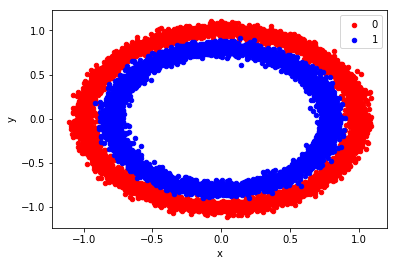

In [ ]:
from sklearn.datasets import make_circles
from matplotlib import pyplot
from pandas import DataFrame
# generate 2d classification dataset
X, y = make_circles(n_samples=10000, noise=0.04)
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

Train set: (8000, 2) (8000,)
Test set: (2000, 2) (2000,)


[(-1.1123006183092397, 1.1051398563321988),
 Text(0, 0.5, '$X_2$'),
 (-1.1107932613588891, 1.0916309024161017),
 Text(0.5, 0, '$X_1$'),
 None]

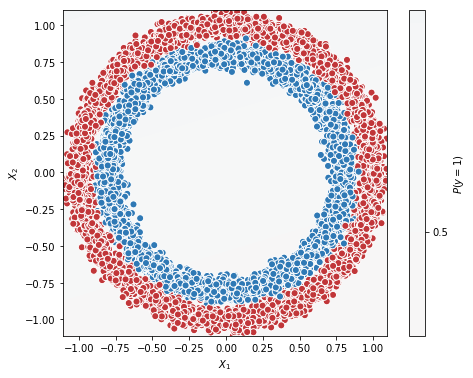

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

# Ajuste del modelo.
LR = LogisticRegression(C=0.01, solver='newton-cg').fit(X_train,y_train)

xx, yy = np.mgrid[X.min(0)[0]:X.max(0)[0]:.01, X.min(0)[1]:X.max(0)[1]:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = LR.predict_proba(grid)[:, 1].reshape(xx.shape)
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(X.min(0)[0], X.max(0)[0]), ylim=(X.min(0)[1], X.max(0)[1]),
       xlabel="$X_1$", ylabel="$X_2$")

En este caso, asigna a todos los puntos una probabilidad cercana a 0.5, lo que indica una mala clasificación, ya que todos los puntos estarían dentro de la frontera de decisión.

In [ ]:
cv_scores = cross_val_score(LR,X,y)

print("Los puntajes de la validación cruzada son:", cv_scores)

Los puntajes de la validación cruzada son: [0.49490102 0.48380324 0.48589436]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


**Conclusión:** En los casos en donde la **frontera de decisión** no es lineal para datos distribuidos en anillos concentricos, el algoritmo de regresión logística presenta un desempeño muy pobre; en este caso, hemos obtenido un porcentaje de clasificaciones correctas del 49%, mediante una evaluación cruzada con tres folds.

#### Ejercicio: 

De las siguiente base de datos de una empresa de telecomunicaciones, construya un modelo de regresión logítica que prediga el abandono del cliente (variable churn), siguiendo los pasos que se enumeran a continuación:

1. Cargue la base de datos de la dirección "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/ChurnData.csv" y visualice los datos.
2. Guarde en un nuevo dataset las características `['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip',   'callcard', 'wireless','churn']`. La variable churn representa el abandono; consulte el tipo de esta variable y en caso de no ser `int` convirtala a este tipo.
3. Visualice el número de elementos total de la nuevo tabla.
4. Guarde las variables predictoras (todas menos churn) como un array en una variable X y la variable objetivo (churn), como array también, en una variable y.
5. Normalice la variable x y ajuste los datos.
6. Realice un ajuste mediante regresión logística de los datos, usando 5 folds y evaluando el puntaje obtenido promedio.

Hacer doble click <b>aquí</b> para ver la solución:

<!-- Respuesta:
# Punto 1:

import numpy as np
import pandas as pd
from sklearn import preprocessing

df = pd.read_csv("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/ChurnData.csv")
df.head()

# Punto 2

df = df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip',   'callcard', 'wireless','churn']]
df['churn'] = df['churn'].astype('int')
df.head()

# Punto 3

df.shape

# Punto 4

X = np.asarray(df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip']])
y = np.asarray(df['churn'])

# Punto 5

X = preprocessing.StandardScaler().fit(X).transform(X)

# Punto 6.

from sklearn.model_selection import cross_val_score 
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(C=0.01, solver='liblinear')
print(np.mean(cross_val_score(LR,X,y,cv=5)))
-->